There are some cells that are labelled incorrectly. We correct them here. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read in old labels
original_labels = pd.read_csv('/work/users/o/e/oem/PHASER/data/wayne_rpe/labels_original.csv')

original_labels

,cell_id,pred_phase,pred_age
0,0,G1,615.790400
1,1,S,726.578667
2,2,G1,297.294400
3,3,G2,805.475200
4,5,G1,109.694400
...,...,...,...
8845,8897,G1,206.972800
8846,8898,G2,899.638400
8847,8899,G1,101.033600
8848,8900,S,733.546667


In order to correct these the labels on some cells, we look at the PHATE plot and the incorrect predictions of the AlexNet model trained on the original (uncorrected data). The areas that the model got wrong but appear to be correct, we change. 

First, we need to get the PHATE mappings and merge them into this df.

In [4]:
manifold = pd.read_csv('/work/users/o/e/oem/PHASER/data/wayne_rpe/control_manifold_allfeatures.csv')

manifold = manifold.rename(columns={'Unnamed: 0.1.1': 'cell_id'})

manifold = manifold[['cell_id', 'PHATE_1', 'PHATE_2']]

# make sure the id columns match
all(manifold['cell_id'] == original_labels['cell_id'])

/tmp/ipykernel_1107178/476069099.py:1: DtypeWarning: Columns (299) have mixed types. Specify dtype option on import or set low_memory=False.
  manifold = pd.read_csv('/work/users/o/e/oem/PHASER/data/wayne_rpe/control_manifold_allfeatures.csv')


True

In [5]:
# Now we can join the PHATE maps to the cell ids in the original labels
phate_maps = pd.merge(original_labels, manifold, how='left', on='cell_id')

phate_maps = phate_maps.set_index('cell_id')

# Drop any cells that don't have pred_phase
phate_maps = phate_maps.dropna(subset='pred_phase')

# Drop any M Phase cells because we don't use those
phate_maps = phate_maps[phate_maps['pred_phase'] != 'M']

phate_maps

,pred_phase,pred_age,PHATE_1,PHATE_2
cell_id,,,,
0,G1,615.790400,-0.020654,0.007907
1,S,726.578667,0.025945,-0.000735
2,G1,297.294400,0.002961,-0.004575
3,G2,805.475200,0.034884,0.002944
5,G1,109.694400,-0.019039,0.000584
...,...,...,...,...
8897,G1,206.972800,-0.018843,0.000029
8898,G2,899.638400,0.039467,0.006623
8899,G1,101.033600,-0.021200,0.000573


In [6]:
# Now read in the model predictions

predictions = pd.read_csv('/work/users/o/e/oem/PHASER/results/inference_on_all_cells.csv', index_col='cell_id')

# Sanity check to make sure the dfs are equal length

assert len(predictions) == len(phate_maps)

predictions.reset_index(inplace=True)
predictions = predictions[['cell_id', 'prediction', 'confidence']]

predictions['cell_id'] = predictions['cell_id'].str.replace('cell_', '').astype(int)

predictions.set_index('cell_id', inplace=True)

predictions

,prediction,confidence
cell_id,,
4415,S,0.940694
8147,G1,0.988647
3629,S,0.999434
1894,G1,0.998362
5900,G1,0.993839
...,...,...
3227,S,0.999781
965,G1,0.999068
1247,G1,0.999089


In [7]:
# Now merge this onto the PHATE maps
phate_w_preds = pd.merge(phate_maps, predictions, how='left', on='cell_id')

print(phate_w_preds)

        pred_phase    pred_age   PHATE_1   PHATE_2 prediction  confidence
cell_id                                                                  
0               G1  615.790400 -0.020654  0.007907         G1    0.992057
1                S  726.578667  0.025945 -0.000735          S    0.991269
2               G1  297.294400  0.002961 -0.004575          S    0.957815
3               G2  805.475200  0.034884  0.002944         G2    0.987160
5               G1  109.694400 -0.019039  0.000584         G1    0.998630
...            ...         ...       ...       ...        ...         ...
8897            G1  206.972800 -0.018843  0.000029         G1    0.997565
8898            G2  899.638400  0.039467  0.006623         G2    0.997327
8899            G1  101.033600 -0.021200  0.000573         G1    0.988352
8900             S  733.546667  0.027874 -0.000248         G2    0.925681
8901            G1  237.419200 -0.017125 -0.001093         G1    0.997696

[5875 rows x 6 columns]


In [8]:
# Let's see what the minimum confidence is 
min(phate_w_preds['confidence'])

0.3720490038394928

<Axes: xlabel='confidence', ylabel='Count'>

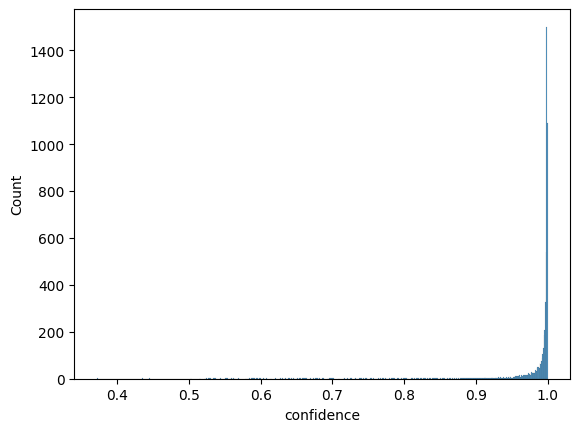

In [9]:
# Let's see what the confidence score ranges were for correct predictions
conf_corr = phate_w_preds[phate_w_preds['pred_phase'] == phate_w_preds['prediction']]['confidence']

sns.histplot(conf_corr)

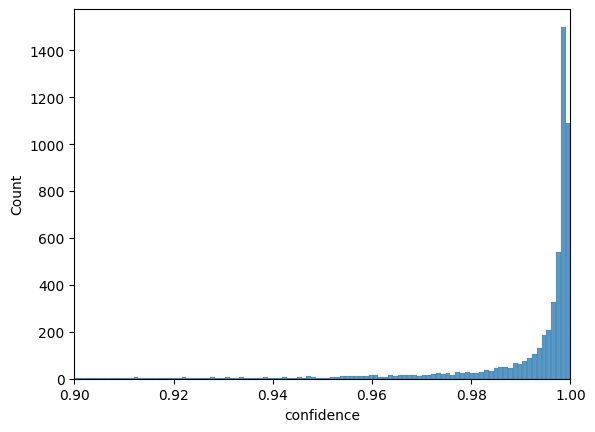

In [10]:
# Zoom in on the range 0.9 - 1.0
sns.histplot(conf_corr)

plt.xlim(0.9, 1.0)
plt.show()

<Axes: ylabel='confidence'>

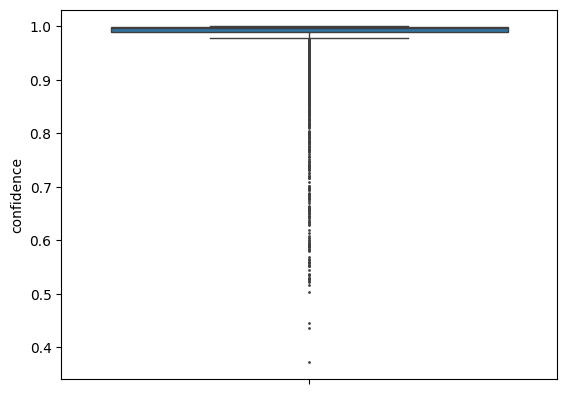

In [11]:
# As a boxplot
sns.boxplot(conf_corr, fliersize=1)

<Axes: xlabel='confidence', ylabel='Count'>

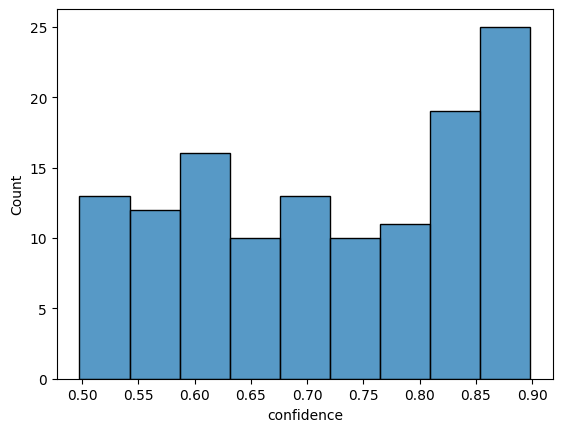

In [27]:
# Now look at stats for incorrect
conf_incorr = phate_w_preds[phate_w_preds['pred_phase'] != phate_w_preds['prediction']]['confidence']

sns.histplot(conf_incorr)

In [28]:
conf_incorr

cell_id
35      0.769859
104     0.639244
151     0.659642
176     0.559982
396     0.513202
          ...   
8773    0.837083
8808    0.600244
8811    0.861610
8823    0.745905
8861    0.870931
Name: confidence, Length: 129, dtype: float64

<Axes: ylabel='confidence'>

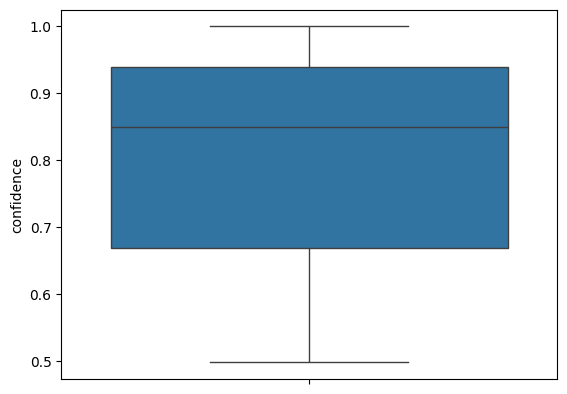

In [13]:
# As a boxplot
sns.boxplot(conf_incorr)

In [14]:
# Filter out the cells where the prediction and real labels don't match
incorrect = phate_w_preds[phate_w_preds['pred_phase'] != phate_w_preds['prediction']]
print(incorrect)

        pred_phase    pred_age   PHATE_1   PHATE_2 prediction  confidence
cell_id                                                                  
2               G1  297.294400  0.002961 -0.004575          S    0.957815
35              G1  689.451733 -0.010432  0.008175         G2    0.769859
104              S  782.820267  0.030304  0.000503         G2    0.639244
130              S  949.430933  0.036186  0.005909         G2    0.999879
139             G1  311.230933 -0.003478 -0.003379          S    0.939244
...            ...         ...       ...       ...        ...         ...
8811            G1  266.937067 -0.006974 -0.002352          S    0.861610
8823             S  550.985067 -0.011480  0.002426         G2    0.745905
8848            G1  276.971200  0.003325 -0.004514          S    0.979936
8861            G1  165.382400 -0.012319 -0.001346          S    0.870931
8900             S  733.546667  0.027874 -0.000248         G2    0.925681

[202 rows x 6 columns]


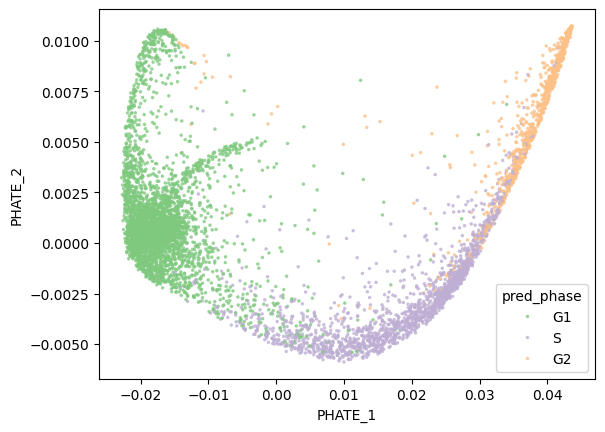

In [15]:
# Now we can plot the cells and see their PHATE mappings

sns.scatterplot(data=phate_w_preds, x='PHATE_1', y='PHATE_2', hue='pred_phase', 
                s=5, edgecolor=None, palette='Accent', alpha=0.8)

plt.show()

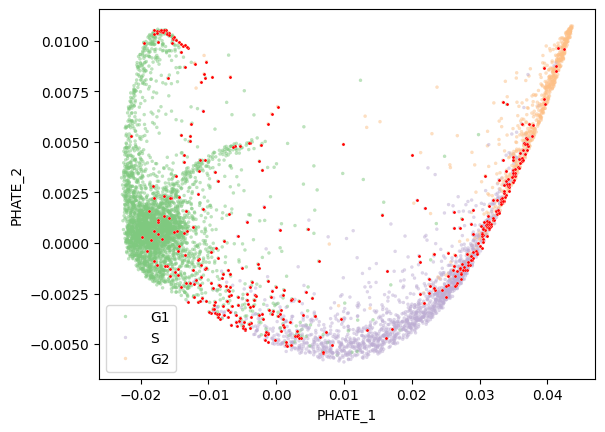

In [16]:
# Let's see where all the low confidence cells are:
low_conf = phate_w_preds[phate_w_preds['confidence'] < 0.9]
sns.scatterplot(data=phate_w_preds, x='PHATE_1', y='PHATE_2', hue='pred_phase', 
                s=5, edgecolor=None, palette='Accent', alpha=0.5)
sns.scatterplot(data=low_conf, x='PHATE_1', y='PHATE_2', color='red', s=5)

plt.show()

We can see that mainly, the low-confidence cells are at transition points. If we further lower the confidence threshhold (less than 0.7) we can see the ultra-low confidence cells.

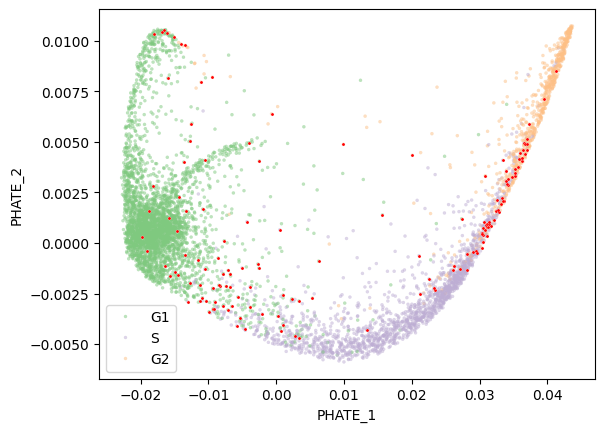

In [17]:
ult_low_conf = phate_w_preds[phate_w_preds['confidence'] < 0.7]
sns.scatterplot(data=phate_w_preds, x='PHATE_1', y='PHATE_2', hue='pred_phase', 
                s=5, edgecolor=None, palette='Accent', alpha=0.5)
sns.scatterplot(data=ult_low_conf, x='PHATE_1', y='PHATE_2', color='red', s=5)

plt.show()

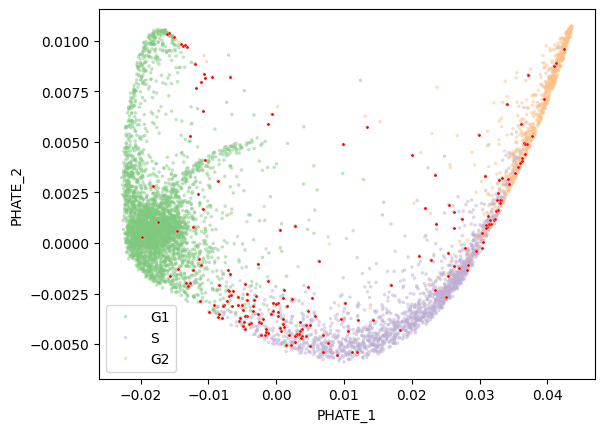

In [18]:
# Now overlay the incorrect predictions instead
sns.scatterplot(data=phate_w_preds, x='PHATE_1', y='PHATE_2', hue='pred_phase', 
                s=5, edgecolor=None, palette='Accent', alpha=0.5)
sns.scatterplot(data=incorrect, x='PHATE_1', y='PHATE_2', color='red', s=5)

plt.show()

We are going to flag the cells where the prediction does not equal the true label and the model is confident in its answer. We can see different confidence levels below:

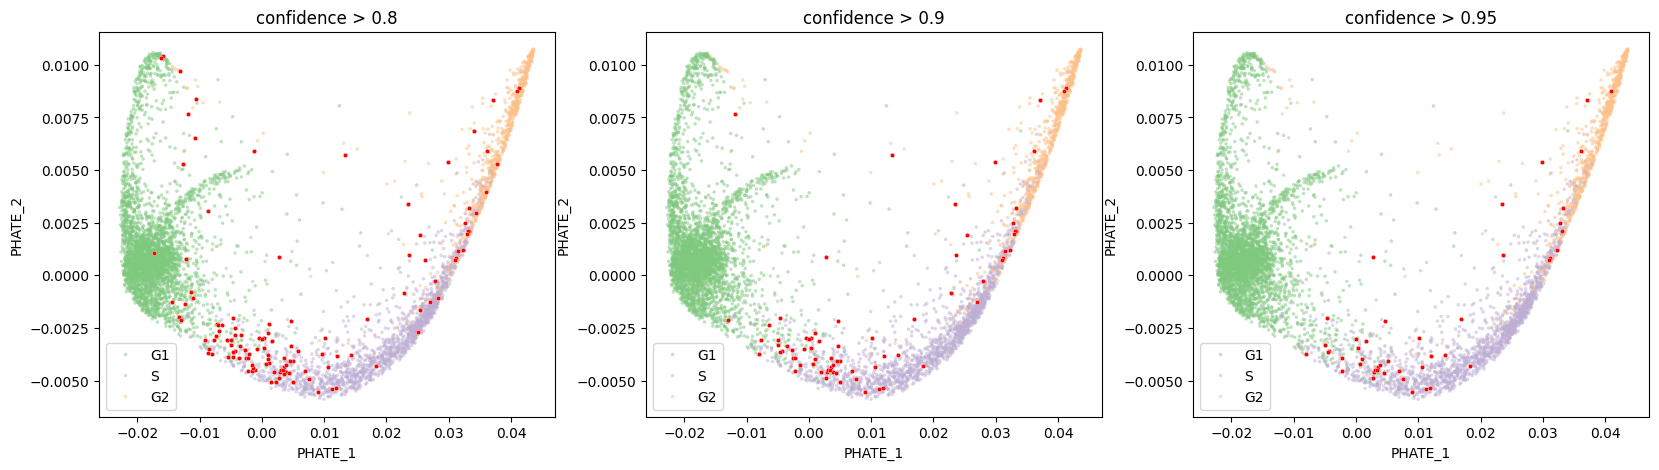

In [19]:
confidence_p8 = incorrect[incorrect['confidence'] > 0.8]
confidence_p9 = incorrect[incorrect['confidence'] > 0.9]
confidence_p95 = incorrect[incorrect['confidence'] > 0.95]

fig, axis = plt.subplots(ncols=3, figsize=(20, 5))
sns.scatterplot(data=phate_w_preds, x='PHATE_1', y='PHATE_2', hue='pred_phase', 
                s=5, edgecolor=None, palette='Accent', alpha=0.5, ax=axis[0])
sns.scatterplot(data=confidence_p8, x='PHATE_1', y='PHATE_2', color='red', 
                s=10, ax=axis[0]).set_title('confidence > 0.8')
sns.scatterplot(data=phate_w_preds, x='PHATE_1', y='PHATE_2', hue='pred_phase', 
                s=5, edgecolor=None, palette='Accent', alpha=0.5, ax=axis[1])
sns.scatterplot(data=confidence_p9, x='PHATE_1', y='PHATE_2', color='red', 
                s=10, ax=axis[1]).set_title('confidence > 0.9')
sns.scatterplot(data=phate_w_preds, x='PHATE_1', y='PHATE_2', hue='pred_phase', 
                s=5, edgecolor=None, palette='Accent', alpha=0.5, ax=axis[2])
sns.scatterplot(data=confidence_p95, x='PHATE_1', y='PHATE_2', color='red', 
                s=10, ax=axis[2]).set_title('confidence > 0.95')
plt.show()


Let's see what predictions we have for each of these confidences:

In [20]:
print('----------Confidence > 0.8----------')
print(confidence_p8.groupby(['pred_phase', 'prediction']).size().reset_index(name='Count'))

print('\n\n----------Confidence > 0.9----------')
print(confidence_p9.groupby(['pred_phase', 'prediction']).size().reset_index(name='Count'))

print('\n\n----------Confidence > 0.95----------')
print(confidence_p95.groupby(['pred_phase', 'prediction']).size().reset_index(name='Count'))


----------Confidence > 0.8----------
  pred_phase prediction  Count
0         G1         G2      3
1         G1          S     87
2         G2         G1      6
3         G2          S      4
4          S         G1      1
5          S         G2     21


----------Confidence > 0.9----------
  pred_phase prediction  Count
0         G1         G2      1
1         G1          S     53
2         G2         G1      2
3         G2          S      1
4          S         G2     16


----------Confidence > 0.95----------
  pred_phase prediction  Count
0         G1         G2      1
1         G1          S     34
2         G2          S      1
3          S         G2      9


The majority of incorrect predictions are cells that were predicted to be S while they were marked as G1. This is apparent from the plots. It looks like confidence > 0.9 is the sweet spot so we will be correcting all of these. There are 73 such cells.

In [21]:
confidence_p9.loc[:, 'pred_phase'] = confidence_p9['prediction']

# Check that that worked
all(confidence_p9['pred_phase'] == confidence_p9['prediction'])

True

In [22]:
# Now update the original dataframe
phate_w_preds.update(confidence_p9)

In [23]:
# Now save the corrected dataframe
final = phate_w_preds[['pred_phase', 'pred_age', 'PHATE_1', 'PHATE_2']]
final.to_csv('/work/users/o/e/oem/PHASER/data/wayne_rpe/labels_corrected.csv')

<Axes: ylabel='confidence'>

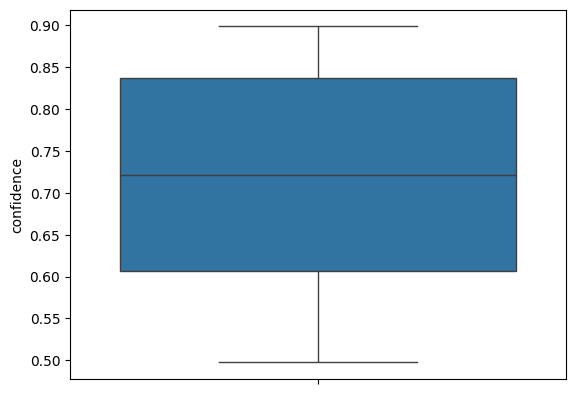

In [24]:
# Let's look at what the incorrect values boxplot looks like now

conf_incorr = phate_w_preds[phate_w_preds['pred_phase'] != phate_w_preds['prediction']]['confidence']

sns.boxplot(conf_incorr)

<Axes: xlabel='confidence', ylabel='Count'>

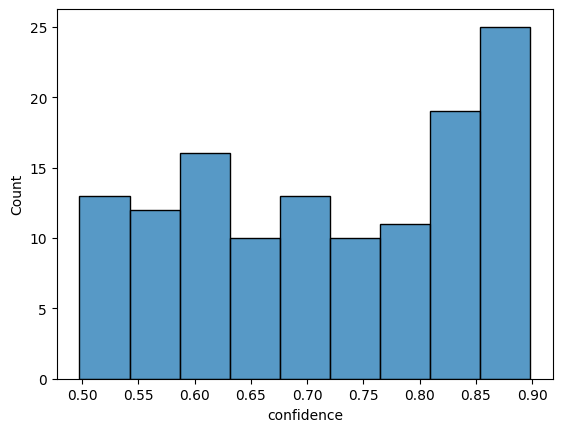

In [25]:
sns.histplot(conf_incorr)